In this notebook we'll get a feel for the Fashion MNIST image dataset and the model we'll be using to classify those images.

In [previous notebook](./explore_data_and_model.ipynb)

##  Setup

In [1]:
import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt

# filter out FutureWarnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Supress Tensorflow Warnings
import tensorflow.compat.v1.logging as logging
logging.set_verbosity(logging.ERROR)

# custom model class
from cnn import FashionMNISTCNN

Using TensorFlow backend.


## The Fashion MNIST image data set

More information on the dataset see [Github](https://github.com/zalandoresearch/fashion-mnist) or [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist). We'll use the `.csv` files from Kaggle for data exploration.

In [2]:
train_data, val_data = pd.read_csv('data/train.csv'), pd.read_csv('data/val.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [4]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


- There are 60,000 images in the training set, and 10,000 in the validation set. 
- There are 785 features - a class label and 784 pixels. A row of 784 pixels is a flattened 28 x 28 pixel array

### Class representative images

There are 10 image classes

In [5]:
def add_class_str_labels(df):
    class_str_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
                "Shirt", "Sneaker", "Bag", "Ankle Boot"]
    # dict for mapping labels to string labels
    class_mapping = {i: label for (i, label) in enumerate(class_str_labels)}
    df['str_label'] = df['label'].apply(lambda x: class_str_labels[x])
    
add_class_str_labels(train_data)
add_class_str_labels(val_data)

We'll collect 5 images from each of the 10 classes and plot them

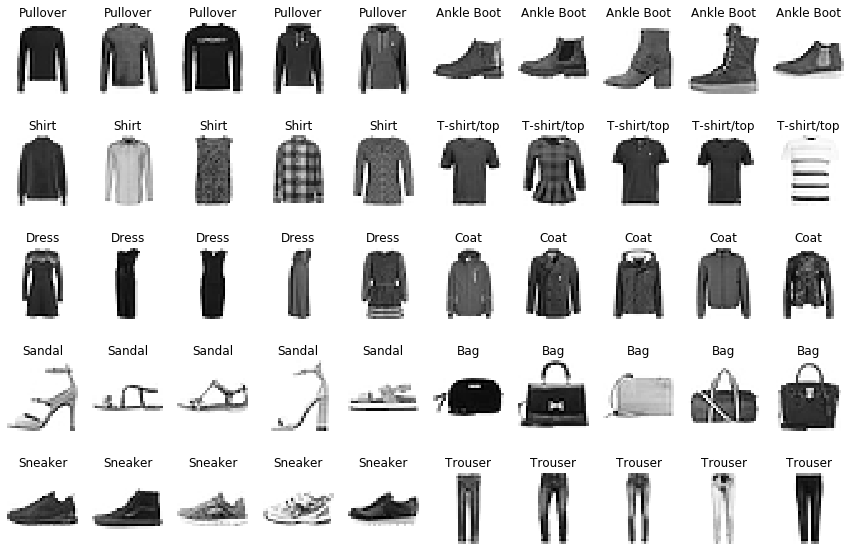

In [6]:
def get_class_images(df, class_str_label, num_images=5):
    # slice all rows for this class
    class_slice = df[df['str_label'] == class_str_label]
    # get 5 random indices
    indices = np.random.choice(class_slice.index.values, size=5, replace=False)
    # slice images for these indices
    image_slice = class_slice.loc[indices, : ]
    # return array of 28 x 28 images
    return image_slice.drop(columns=['label', 'str_label']).values.reshape(5, 28, 28)

def plot_sample_images(df):
    class_str_labels=df['str_label'].unique()
    fig, ax = plt.subplots(5, 10, figsize=(15, 10))
    for (i, label) in enumerate(class_str_labels):
        class_images = get_class_images(df, label)
        for (j, image) in enumerate(class_images):
            ax[i//2, j + 5*(i%2)].imshow(image, cmap='Greys')
            ax[i//2, j + 5*(i%2)].axis('off')
            ax[i//2, j + 5*(i%2)].set_title(label)
            
plot_sample_images(train_data)

### Class distributions

We'll look at how the images are distributed across the image classes in the train and validation sets

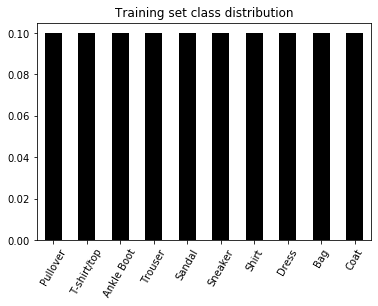

In [7]:
# plot class distributions for training and validation data
def plot_class_distribution(df, title):
    class_dist = train_data['str_label'].value_counts() / len(train_data)
    class_dist.plot(kind='bar', color='k')
    plt.title(title)
    plt.xticks(rotation=60)

plot_class_distribution(train_data, 'Training set class distribution')

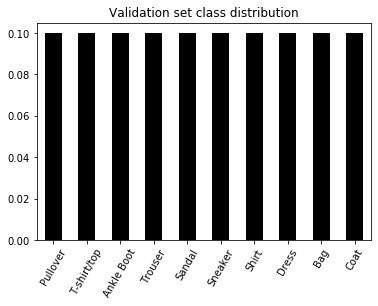

In [8]:
plot_class_distribution(val_data, 'Validation set class distribution')

The classes are perfectly balanced. 

Before we begin training a model, we'll create a perfectly balanced test set from the training data

In [9]:
def balanced_test_split(df, size=10000):
    np.random.seed(27)
    df = df.copy()
    # get class names
    class_str_labels = df['str_label'].unique()
    # store slices for later concatenation
    slices = []
    # get slices for all the classes
    for class_str_label in class_str_labels:
        # slice all rows for this class
        class_slice = df[df['str_label'] == class_str_label]
        # get indices for test rows
        indices = np.random.choice(class_slice.index.values, 
                                             size=size//10, 
                                             replace=False)
        # slice for these indices
        slices += [class_slice.loc[indices, : ]]
        # drop rows for these indices 
        df = df.drop(index=indices)
    # collect slices into a dataframe
    test_df = pd.concat(slices, ignore_index=True)
    return df, test_df

train_data, test_data = balanced_test_split(train_data)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 59999
Columns: 786 entries, label to str_label
dtypes: int64(785), object(1)
memory usage: 300.2+ MB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 786 entries, label to str_label
dtypes: int64(785), object(1)
memory usage: 60.0+ MB


## Keras CNN Model for classification

### Overview 

The model we'll use is a convolutional neural network build using Keras with Tensorflow backend. The CNN is implemented as a wrapper for the keras functional API class `keras.models.Model`

The model architecture follows the convention of several convolutional/pooling blocks, then a flattening, followed by a few fully connected layers and finally a softmax layer.

- *Convolutional/Pooling blocks* - Each convolutional block follows the sequence:
     1. Zero padding
     2. 2D convolution
     3. Batch Normalization
     4. Activation
     5. 2D Max Pooling
     
- *Fully Connected layers* - Each fully connected layer follows the sequence:
    1. Batch Normalization
    2. Dropout
    3. Activation
    

In [2]:
INPUT_SHAPE = (28, 28, 1)
model = FashionMNISTCNN(INPUT_SHAPE)

The `FashionMNISTCNN` class constructor accepts a dictionary of architecture parameters which constructs an arbitary number of conv/pool blocks followed by an arbitarary number of fully connected layers. 

By default the CNN has 3 conv/pool layers, 2 fully connected layers, and a softmax layer.

In [13]:
# Default parameters for convolutional/pooling blocks
model.conv_params

{'conv0': {'conv0_pad': 1,
  'conv0_channels': 32,
  'conv0_filter': 3,
  'conv0_stride': 1,
  'conv0_pool': 1,
  'conv0_activation': 'relu'},
 'conv1': {'conv1_pad': 1,
  'conv1_channels': 64,
  'conv1_filter': 3,
  'conv1_stride': 1,
  'conv1_pool': 2,
  'conv1_activation': 'relu'},
 'conv2': {'conv2_pad': 1,
  'conv2_channels': 128,
  'conv2_filter': 3,
  'conv2_stride': 1,
  'conv2_pool': 2,
  'conv2_activation': 'relu'}}

In [14]:
# Default parameters for fully connected layers
model.fc_params

{'fc0': {'fc0_neurons': 512, 'fc0_activation': 'relu'},
 'fc1': {'fc1_neurons': 256, 'fc1_activation': 'relu'},
 'fc2': {'fc2_neurons': 10, 'fc2_activation': 'softmax'}}

We'll inspect the default model with keras built in summary

In [15]:
model.summary()

Model: "fashionmnistcnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv0_pad (ZeroPadding2D)    (None, 30, 30, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
conv0_bn (BatchNormalization (None, 28, 28, 32)        128       
_________________________________________________________________
conv0_act (Activation)       (None, 28, 28, 32)        0         
_________________________________________________________________
conv0_pool (MaxPooling2D)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 30, 30, 32)  

### Train default model locally

We'll train the model for a few epochs locally to get a rough sense of how it's going to go

In [3]:
# prepare data for model fitting
X_train, Y_train, X_val, Y_val, X_test, Y_test = model.load_data()
X_train, Y_train, X_val, Y_val, X_test, Y_test = model.prepare_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)

In [17]:
# train model for a few epochs with no dropout
model.compile()
history = model.fit(X_train, Y_train, X_val, Y_val, epochs=5, batch_size=50)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 640s 13ms/step - loss: 0.3524 - acc: 0.8742 - val_loss: 0.3688 - val_acc: 0.8599

Epoch 00001: val_acc improved from -inf to 0.85990, saving model to models/keras_checkpoints/FashionMNISTCNN-epoch-01-val_acc-0.8599.hdf5
best_val_acc: 0.8598999953269959
